# Obligatorisk innlevering 2 - oppgave 2

I denne oppgaven skal vi forsøke å forutsi oppsigelser ved en arbeidsplass basert på en rekke variabler som f.eks alder, kjønn, utdannelse, lønn, osv.

In [417]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [419]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett2.csv")

### Preprosessering:
For å forenkle håndteringen av kategoriske data har jeg her skrevet noe kode som gjør om strenger til intergers

Følgende kolonner er formatert som *object* og inneholder kategoriske variabler i form av strenger

In [422]:
kolonner_obj = df.select_dtypes(include=['object']).columns
print(kolonner_obj)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


I koden under omformer jeg strengene til integers og gir dere "nøkkelen" til å konvertere det tilbake igjen

In [425]:
for i in kolonner_obj:
    print("-----------")
    print(i)
    print("-----------")
    for num, j in enumerate(list(df[i].unique())):
        print("{} = {}".format(j,num))
        df[i].loc[df[i]==j] = num
    df[i] = pd.to_numeric(df[i])

-----------
BusinessTravel
-----------
Travel_Frequently = 0
Travel_Rarely = 1
Non-Travel = 2
-----------
Department
-----------
Research & Development = 0
Sales = 1
Human Resources = 2
-----------
EducationField
-----------
Medical = 0
Other = 1
Marketing = 2
Life Sciences = 3
Technical Degree = 4
Human Resources = 5
-----------
Gender
-----------
Male = 0
Female = 1
-----------
JobRole
-----------
Laboratory Technician = 0
Sales Representative = 1
Sales Executive = 2
Healthcare Representative = 3
Manager = 4
Manufacturing Director = 5
Research Scientist = 6
Human Resources = 7
Research Director = 8
-----------
MaritalStatus
-----------
Married = 0
Divorced = 1
Single = 2
-----------
Over18
-----------
Y = 0
-----------
OverTime
-----------
Yes = 0
No = 1


C:\Users\gunil\AppData\Local\Temp\ipykernel_13732\3482823818.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[i].loc[df[i]==j] = num
C:\Users\gunil\AppData\Local\Temp\ipykernel_13732\3482823818.py:7: SettingWithCopyWarning: 
A value is

I outputen fra koden nedenfor viser datatypen til de forskjellige kolonnene, som nå etter preprosesseringen bare består av integers (int64). 

In [428]:
print(df.dtypes)

id                          int64
Age                         int64
BusinessTravel              int64
DailyRate                   int64
Department                  int64
DistanceFromHome            int64
Education                   int64
EducationField              int64
EmployeeCount               int64
EnvironmentSatisfaction     int64
Gender                      int64
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobRole                     int64
JobSatisfaction             int64
MaritalStatus               int64
MonthlyIncome               int64
MonthlyRate                 int64
NumCompaniesWorked          int64
Over18                      int64
OverTime                    int64
PercentSalaryHike           int64
PerformanceRating           int64
RelationshipSatisfaction    int64
StandardHours               int64
StockOptionLevel            int64
TotalWorkingYears           int64
TrainingTimesLastYear       int64
WorkLifeBalanc

In [430]:
# Her deler jeg datasettet inn i egenskaper (X) og target (y) (fjerner også den første kolonnen siden det bare er en ID 
# og har dermed ingen prediktiv verdi)

X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

# PS: Ikke endre denne kodecellen!

#### Oppgave 2.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? Begrunn svaret

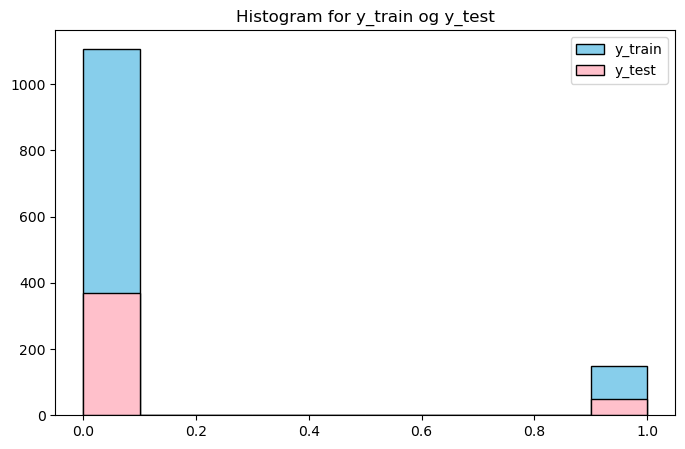

In [433]:
# y_train og y_test
plt.figure(figsize=(8, 5))
plt.hist(y_train, color='skyblue', edgecolor="black", label='y_train')
plt.hist(y_test, color='pink', edgecolor="black", label='y_test')
plt.title("Histogram for y_train og y_test")
plt.legend()
plt.show()

**Svar:**

Basert på histogrammet, kan man se at dette er et klassifiseringsproblem. Det er fordi man ser at det er to diskrete variabeler, 0 og 1, noe som tilsier at verdien er binær. Man ser også at det ikke er noen verdier som ligger mellom 0 og 1, feks 0.5, som tilsier at dette ikke er kontinuerlige verdier.

#### Oppgave 2.2)
Velg to modeller og gjør repeterte kryssvalideringer $(10)$ med $K=5$
* Velg hvorvidt du vil bruke "default" hyperparamtre for modellene eller om du vil gjøre et hyperparametersøk
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene skriftlig til slutt 


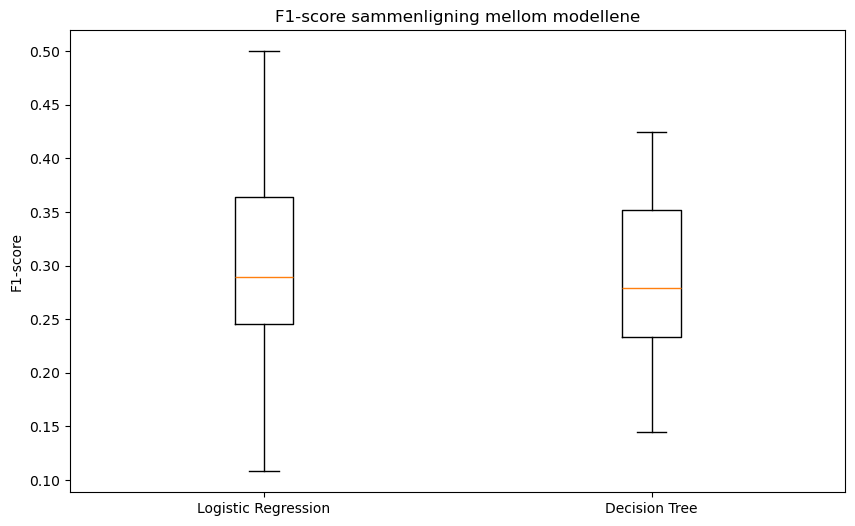

T-test Resultat:
T-statistic: 0.8110506497894754
P-verdi: 0.41930196910046846

Gjennomsnittlig F1-score for Logistic Regression: 0.29651924546079744
Gjennomsnittlig F1-score for Decision Tree: 0.28361753424358954


In [437]:
# Setter opp modellene som pipelines
model1 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=2000, random_state=0))
])

model2 = DecisionTreeClassifier(random_state=0)

# 5-fold kryssvalidering med 10 repetisjoner
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)

# Definer F1-score som scoring-metrikk
f1_scorer = make_scorer(f1_score)

# Utfør kryssvalidering og hent F1-scorene for begge modellene
f1_scores_model1 = cross_val_score(model1, X_train, y_train, cv=cv_strategy, scoring=f1_scorer)
f1_scores_model2 = cross_val_score(model2, X_train, y_train, cv=cv_strategy, scoring=f1_scorer)

# Visualiserer F1-scorene som et boksplot for å sammenligne modellene
plt.figure(figsize=(10, 6))
plt.boxplot([f1_scores_model1, f1_scores_model2], tick_labels=['Logistic Regression', 'Decision Tree'])
plt.title('F1-score sammenligning mellom modellene')
plt.ylabel('F1-score')
plt.show()

# Utfør en tosidig T-test på F1-scorene
t_stat, p_value = stats.ttest_ind(f1_scores_model1, f1_scores_model2)

print("T-test Resultat:")
print("T-statistic:", t_stat)
print("P-verdi:", p_value)

# Gjennomsnittlig F1-score for begge modellene
print("\nGjennomsnittlig F1-score for Logistic Regression:", np.mean(f1_scores_model1))
print("Gjennomsnittlig F1-score for Decision Tree:", np.mean(f1_scores_model2))



**Svar:**

Logistisk regresjon sin gjennomsnitlige F1 score er høyere enn Decision Tree sin F1-score etter kryssvalideringene, noe som sier at logistisk regresjon modellen er noe bedre. Likevel så har de begge ganske lav F1-score, som kan indikere at de ikke vil prestere særlig bra.

#### Oppgave 2.3) 
Tren de samme modellene men denne gangen med et balansert datasett
* Bruk imbalaced learn og SMOTE til å oppsample minioritetsklassen (bare oppsample treningsdataene i kryssvalideringen - ikke valideringsdataene)
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene og sammenlign resultatene med 2.2) 

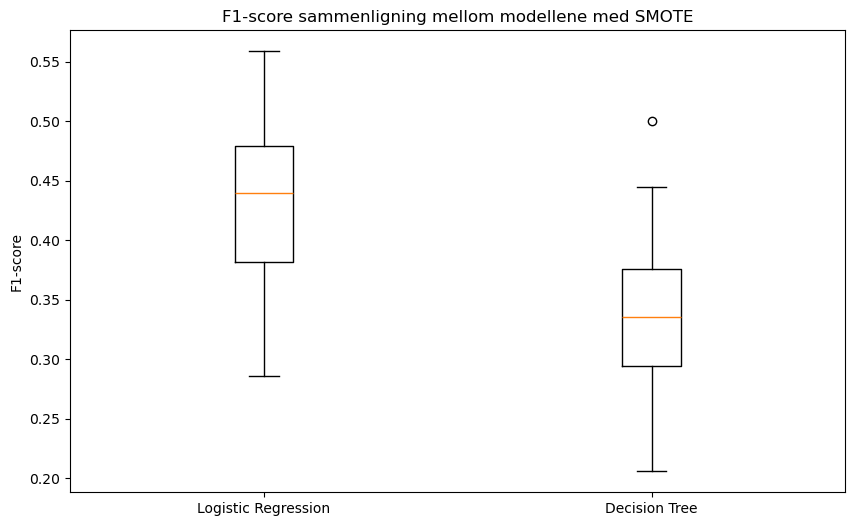

T-test Results:
T-statistic: 7.175392361030794
P-value: 1.391159304158254e-10

Logistic Regression F1-score Mean (SMOTE): 0.4252391838739904
Decision Tree F1-score Mean (SMOTE): 0.33466684423237936


In [443]:
# Definerer SMOTE-instans
smote = SMOTE(random_state=0)

# Sett opp modellene med pipeline inkludert SMOTE, kun for treningsdataene
model1 = ImbPipeline([
    ('smote', smote),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=2000, random_state=0))
])

model2 = ImbPipeline([
    ('smote', smote),
    ('tree', DecisionTreeClassifier(random_state=0))
])

# 5-fold kryssvalidering med 10 repetisjoner
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)

# Definer F1-score som scoring-metrikk
f1_scorer = make_scorer(f1_score)

# Utfør kryssvalidering og hent F1-scorene for begge modellene
f1_scores_model1 = cross_val_score(model1, X_train, y_train, cv=cv_strategy, scoring=f1_scorer)
f1_scores_model2 = cross_val_score(model2, X_train, y_train, cv=cv_strategy, scoring=f1_scorer)

# Visualiser F1-scorene som et boksplot for å sammenligne modellene
plt.figure(figsize=(10, 6))
plt.boxplot([f1_scores_model1, f1_scores_model2], tick_labels=['Logistic Regression', 'Decision Tree'])
plt.title('F1-score sammenligning mellom modellene med SMOTE')
plt.ylabel('F1-score')
plt.show()

# Utfør en tosidig T-test på F1-skårene
t_stat, p_value = stats.ttest_ind(f1_scores_model1, f1_scores_model2)

print("T-test Results:")
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Gjennomsnittlig F1-score for begge modellene
print("\nLogistic Regression F1-score Mean (SMOTE):", np.mean(f1_scores_model1))
print("Decision Tree F1-score Mean (SMOTE):", np.mean(f1_scores_model2))

**Svar:**

Her kan man se at begge modellene får bedre resultat på den gjennomsnittlige F1-scoren. Logistisk regresjon er fortsatt bedre enn decision tree, og her øker fordelen.

#### Oppgave 2.4)
Tren den beste modellen på nytt og utfør prediksjon på testsettet. Mål nå ytelsen på testsettet ved bruk av sensitivitet, spesifisitet og presisjon, itillegg til F1-skår og accuracy

In [447]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Sett opp den beste modellen i en pipeline med SMOTE, StandardScaler, og LogisticRegression
best_model = Pipeline([
    ('smote', SMOTE(random_state=0)),             
    ('scaler', StandardScaler()),                 
    ('logreg', LogisticRegression(max_iter=2000, random_state=0))  
])

# Tren modellen på hele treningssettet
best_model.fit(X_train, y_train)

# Gjør prediksjon på testsettet
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)  # Sensitivitet
f1 = f1_score(y_test, y_pred)

# Beregn spesifisitet fra forvirringsmatrisen
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# Skriv ut resultatene
print("Ytelse på testsettet:")
print("Nøyaktighet (Accuracy):", accuracy)
print("Presisjon (Precision):", precision)
print("Sensitivitet (Recall):", recall)
print("Spesifisitet (Specificity):", specificity)
print("F1-score:", f1)


Ytelse på testsettet:
Nøyaktighet (Accuracy): 0.8428571428571429
Presisjon (Precision): 0.3787878787878788
Sensitivitet (Recall): 0.5
Spesifisitet (Specificity): 0.8891891891891892
F1-score: 0.43103448275862066


#### Oppgave 2.5)
Del opp testsettet basert på kjønn og gjør en analyse av sensitivitet, spesifisitet og presisjon for menn og det samme for kvinner. Skriv ut og diskuter resultatet og forsøk å svar på følgende spørsmål:
* Er modellen like god for begge kjønn? 
* Hvis ikke, hva tror du er årsaken og hvilke tiltak kan vi gjøre for å forbedre modellen? 

In [450]:
X_test_male = X_test[X_test['Gender'] == 1]
y_test_male = y_test[X_test['Gender'] == 1]
X_test_female = X_test[X_test['Gender'] == 0]
y_test_female = y_test[X_test['Gender'] == 0]

# Gjør prediksjon for både menn og kvinner ved å bruke best_model
y_predict_male = best_model.predict(X_test_male)
y_predict_female = best_model.predict(X_test_female)

# Beregn metrikker for menn
cm_male = confusion_matrix(y_test_male, y_predict_male)
tn_male, fp_male, fn_male, tp_male = cm_male.ravel()
sensitivity_male = tp_male / (tp_male + fn_male)  # Sensitivitet (Recall)
specificity_male = tn_male / (tn_male + fp_male)  # Spesifisitet
precision_male = precision_score(y_test_male, y_predict_male)  # Presisjon

# Beregn metrikker for kvinner
cm_female = confusion_matrix(y_test_female, y_predict_female)
tn_female, fp_female, fn_female, tp_female = cm_female.ravel()
sensitivity_female = tp_female / (tp_female + fn_female)  # Sensitivitet (Recall)
specificity_female = tn_female / (tn_female + fp_female)  # Spesifisitet
precision_female = precision_score(y_test_female, y_predict_female)  # Presisjon

# Skriv ut resultatene for menn
print("Ytelse for menn:")
print("Sensitivitet (Recall):", sensitivity_male)
print("Spesifisitet (Specificity):", specificity_male)
print("Presisjon (Precision):", precision_male)

# Skriv ut resultatene for kvinner
print("\nYtelse for kvinner:")
print("Sensitivitet (Recall):", sensitivity_female)
print("Spesifisitet (Specificity):", specificity_female)
print("Presisjon (Precision):", precision_female)

Ytelse for menn:
Sensitivitet (Recall): 0.5
Spesifisitet (Specificity): 0.9411764705882353
Presisjon (Precision): 0.4375

Ytelse for kvinner:
Sensitivitet (Recall): 0.5
Spesifisitet (Specificity): 0.8525345622119815
Presisjon (Precision): 0.36


In [458]:

#Svar: Sensitiviteten er moderat og likt for både kvinner og menn, 50%. Spesifisiteten er ganske høy for både kvinner og menn,
# men menn har høyere med 94%. Presisjon er 0,44 for menn og 0,36 for kvinner noe som er moderat for begge, men menn har høyere.
# Dette antyder at modellen presterer bedre for menn enn kvinner. Årsak til dette kan være ubalanse i datasettet,
# feks skjevheteter basert på kjønn. En mulig forbedring kan være å heller prøve å bruke en annen modell enn logistisk regresjon.


Kjør denne cellen til slutt og legg ved den genererte requirements.txt fila i pull requestet

In [460]:
!pip freeze > requirements.txt